# EDA: Preprocessed NLI Dataset

Quick look at the tokenized NLI triplets in `data/processed/`.

In [1]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np

ds = load_from_disk("processed/")
ds.reset_format()  # expose text columns hidden by set_format
print(f"Rows: {len(ds):,}")
print(f"Columns: {ds.column_names}")

Rows: 275,601
Columns: ['sent0', 'sent1', 'hard_neg', 'sent0_input_ids', 'sent0_attention_mask', 'sent1_input_ids', 'sent1_attention_mask', 'hard_neg_input_ids', 'hard_neg_attention_mask']


## Sample triplets

In [2]:
import pandas as pd

df = ds.select(range(5)).to_pandas()
df[["sent0", "sent1", "hard_neg"]]

,sent0,sent1,hard_neg
0,you know during the season and i guess at at y...,You lose the things to the following level if ...,They never perform recalls on anything.
1,One of our number will carry out your instruct...,A member of my team will execute your orders w...,We have no one free at the moment so you have ...
2,How do you know? All this is their information...,This information belongs to them.,They have no information at all.
3,yeah i tell you what though if you go price so...,The tennis shoes can be in the hundred dollar ...,The tennis shoes are not over hundred dollars.
4,my walkman broke so i'm upset now i just have ...,I'm upset that my walkman broke and now I have...,My walkman still works as well as it always did.


## Text length distributions (in characters)

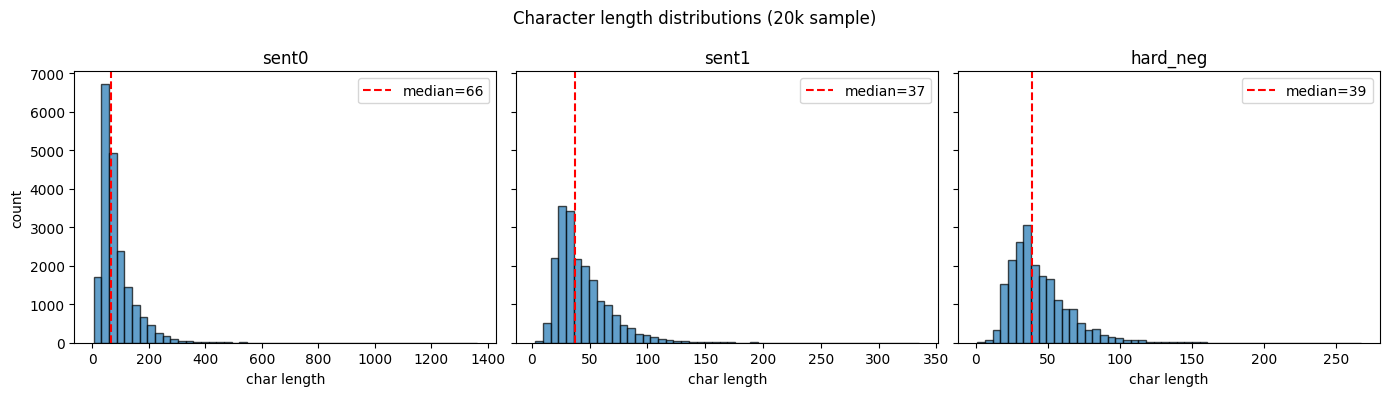

In [3]:
# sample 20k rows for speed
sample = ds.shuffle(seed=42).select(range(20_000))

char_lens = {
    col: [len(s) for s in sample[col]]
    for col in ["sent0", "sent1", "hard_neg"]
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ax, (col, lens) in zip(axes, char_lens.items()):
    ax.hist(lens, bins=50, edgecolor="black", alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("char length")
    ax.axvline(np.median(lens), color="red", linestyle="--", label=f"median={np.median(lens):.0f}")
    ax.legend()
axes[0].set_ylabel("count")
plt.suptitle("Character length distributions (20k sample)")
plt.tight_layout()
plt.show()

## Token length distributions (non-padding tokens)

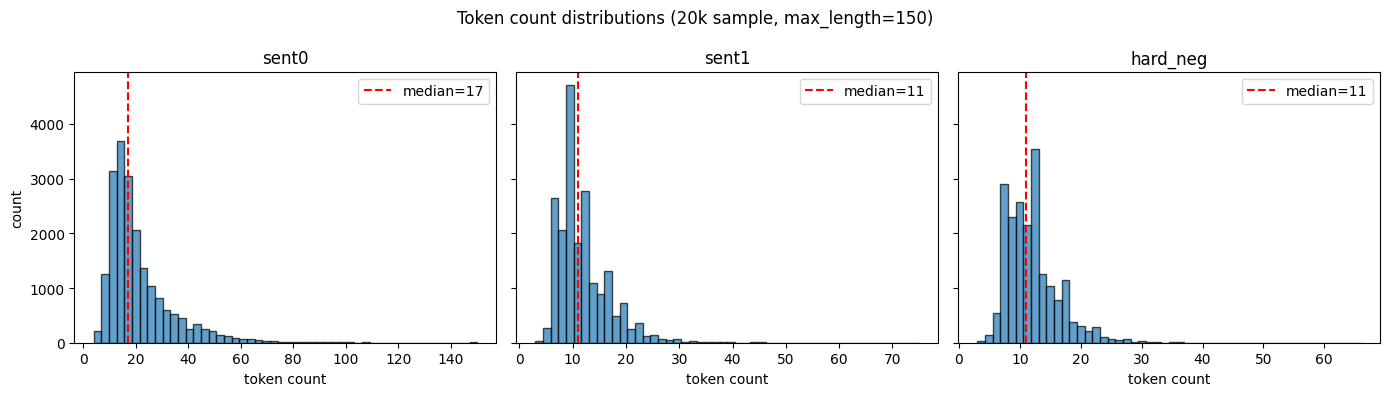

In [4]:
token_lens = {
    col: [int(sum(m)) for m in sample[f"{col}_attention_mask"]]
    for col in ["sent0", "sent1", "hard_neg"]
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ax, (col, lens) in zip(axes, token_lens.items()):
    ax.hist(lens, bins=50, edgecolor="black", alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("token count")
    ax.axvline(np.median(lens), color="red", linestyle="--", label=f"median={np.median(lens):.0f}")
    ax.legend()
axes[0].set_ylabel("count")
plt.suptitle("Token count distributions (20k sample, max_length=150)")
plt.tight_layout()
plt.show()

## Truncation check

How many sequences hit the `max_length=150` ceiling?

In [6]:
MAX_LEN = 150
for col in ["sent0", "sent1", "hard_neg"]:
    n_max = sum(1 for t in token_lens[col] if t >= MAX_LEN)
    pct = n_max / len(token_lens[col]) * 100
    print(f"{col}: {n_max}/{len(token_lens[col])} ({pct:.2f}%) hit max_length={MAX_LEN}")

sent0: 7/20000 (0.03%) hit max_length=150
sent1: 0/20000 (0.00%) hit max_length=150
hard_neg: 0/20000 (0.00%) hit max_length=150


## Summary statistics

In [7]:
rows = []
for col in ["sent0", "sent1", "hard_neg"]:
    cl = np.array(char_lens[col])
    tl = np.array(token_lens[col])
    rows.append({
        "column": col,
        "char_mean": f"{cl.mean():.1f}",
        "char_median": f"{np.median(cl):.0f}",
        "char_max": cl.max(),
        "tok_mean": f"{tl.mean():.1f}",
        "tok_median": f"{np.median(tl):.0f}",
        "tok_max": tl.max(),
        "tok_p95": f"{np.percentile(tl, 95):.0f}",
    })
pd.DataFrame(rows).set_index("column")

,char_mean,char_median,char_max,tok_mean,tok_median,tok_max,tok_p95
column,,,,,,,
sent0,85.2,66,1362,21.2,17,150,47
sent1,43.5,37,335,11.9,11,75,21
hard_neg,43.6,39,267,12.1,11,66,20
